In [1]:
import tensorflow as tf
import pickle
from util import *
from load_data import load_input_file, build_combined_input
from NN_train import *
path_tosave = 'Models/SvS'
mkdir_p(path_tosave)
features_to_ignore = []
#features_to_ignore = ["DPhill_SS"]
features_to_ignore = []

In [2]:
samples, feature_names, class_names, class_no = load_input_file('data/SvS.h5', features_to_ignore)

Found 19 features on the dataset 19 features were loaded: 

DEtall_SS
DPhill_SS
DRll01
HT_jets
HT_lep
Mll01
MtLepMet
jet_pseudoscore_DL1r0
jet_pseudoscore_DL1r1
jet_pseudoscore_DL1r2
jet_pt0_nofwd
met_met
nJets_OR
nJets_OR_DL1r_77
sumPsbtag
sumPsbtag77
randomRunNumber
weight_cuu_0p00_cqu1_0p10_cqu8_0p20
weight_cuu_0p04
 


In [148]:
targets = []
sample0, *other = samples
targets.extend( np.ones( sample0.data().shape[0] ) * sample0.class_label() )
inputs = sample0.data()
targets = np.array(targets, dtype = int )
weights = inputs[:,-1]
inputs = inputs[:,0:-1]
targets = targets[np.where((weights<1) &(weights>0))]
inputs  = inputs[np.where((weights<1) &(weights>0))]
weights = weights[np.where((weights<1) &(weights>0))]
data_len = inputs.shape[0]

In [149]:
weights_cuu = inputs[:,-1]
weights_cqu = inputs[:,-2]
weights_cuu_int = (inputs[:,-1] * 100).astype(int)
weights_cqu_int = (inputs[:,-2] * 100).astype(int)
inputs = inputs[:,0:-3]
feature_names = feature_names[0:-3]
feature_names

['DEtall_SS',
 'DPhill_SS',
 'DRll01',
 'HT_jets',
 'HT_lep',
 'Mll01',
 'MtLepMet',
 'jet_pseudoscore_DL1r0',
 'jet_pseudoscore_DL1r1',
 'jet_pseudoscore_DL1r2',
 'jet_pt0_nofwd',
 'met_met',
 'nJets_OR',
 'nJets_OR_DL1r_77',
 'sumPsbtag',
 'sumPsbtag77']

In [150]:
reweighted_inputs = np.zeros([weights_cuu_int.sum()+weights_cqu_int.sum(),inputs.shape[1]])
targets = np.concatenate([np.zeros(weights_cuu_int.sum()), np.ones(weights_cqu_int.sum())])
counter = 0
for i in range(weights_cuu_int.shape[0]):
    for j in range(weights_cuu_int[i]):
        reweighted_inputs[counter,:] = inputs[i,:]
        counter +=1
for i in range(weights_cqu_int.shape[0]):
    for j in range(weights_cqu_int[i]):
        reweighted_inputs[counter,:] = inputs[i,:]
        counter +=1        

In [155]:
scaler = StandardScaler().fit(reweighted_inputs)
input_scaled = scaler.transform(reweighted_inputs)

In [162]:
input_scaled, X_val, targets, y_val, = train_test_split(input_scaled, targets, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test, = train_test_split(input_scaled, targets, test_size=0.2, random_state=42)
train = (X_train, y_train)
val = (X_val, y_val)
test = (X_test, y_test)

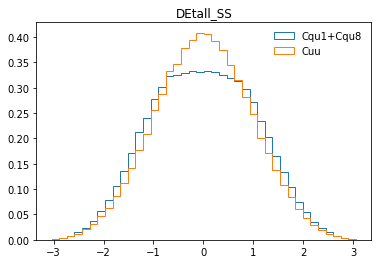

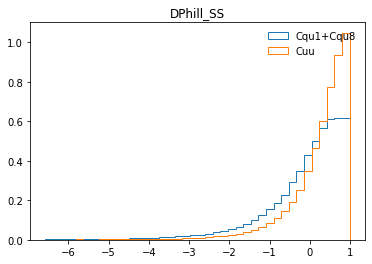

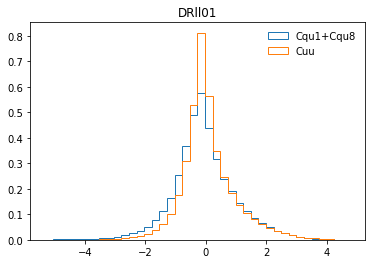

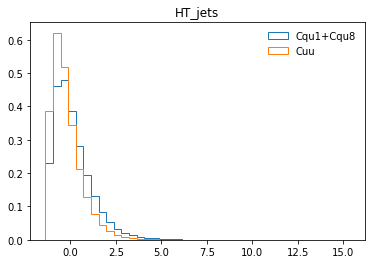

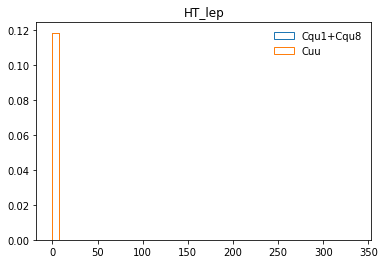

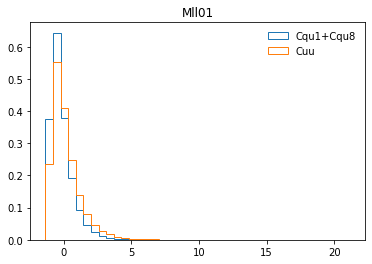

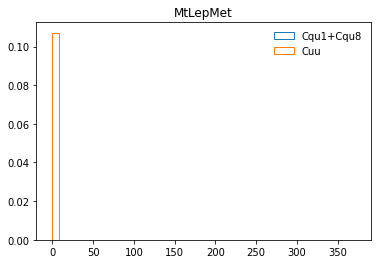

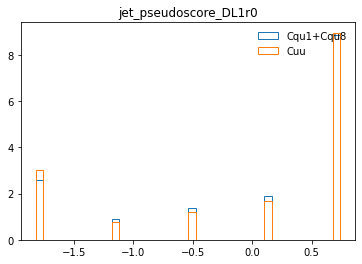

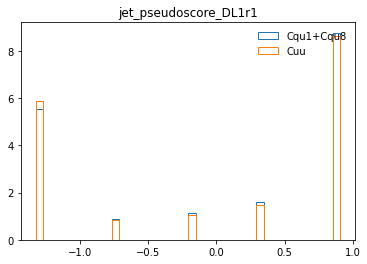

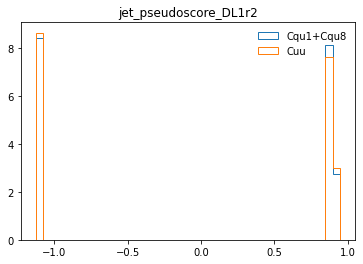

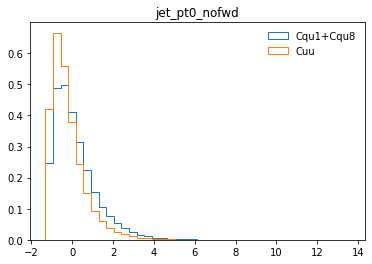

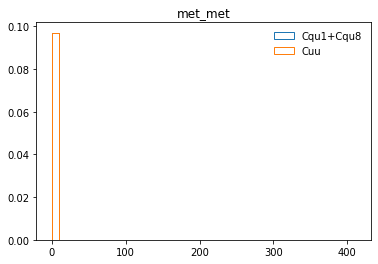

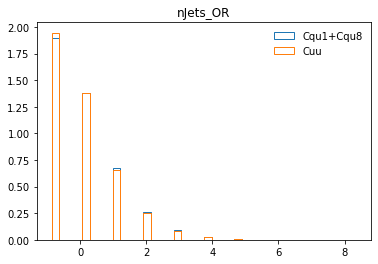

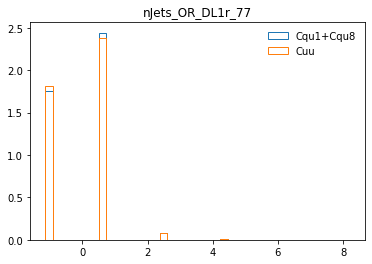

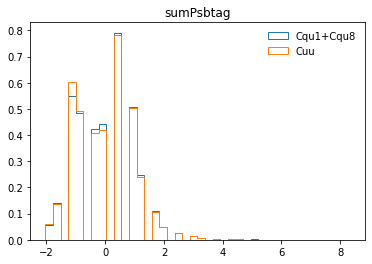

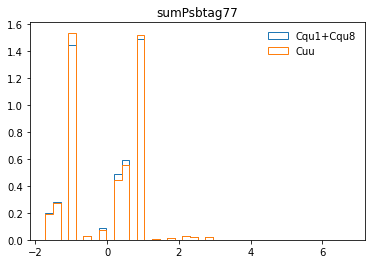

In [174]:
for i in range(train[0].shape[1]):
    max_val = train[0][:,i].max()
    min_val = train[0][:,i].min()
    plt.title(str(feature_names[i]))
    cqu = plt.hist(train[0][:,i][train[1]==1], bins=40, range=(min_val, max_val), histtype='step', label='Cqu1+Cqu8', density=True)
    cuu = plt.hist(train[0][:,i][train[1]==0], bins=40, range=(min_val, max_val), histtype='step', label='Cuu', density=True)
    plt.legend(frameon=False)
    save_name = path_tosave + "/Input_Feature_" + str(i) + ".png"
    plt.savefig(save_name)
    plt.show()

In [176]:
inputs.shape[1]

16

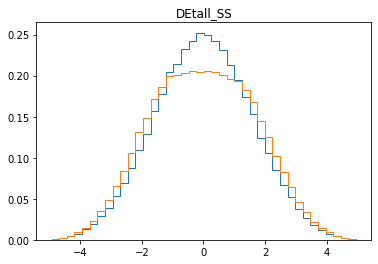

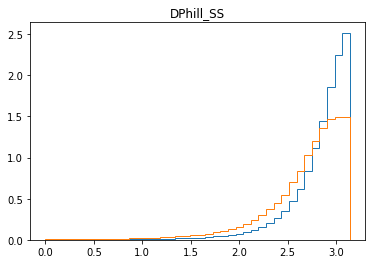

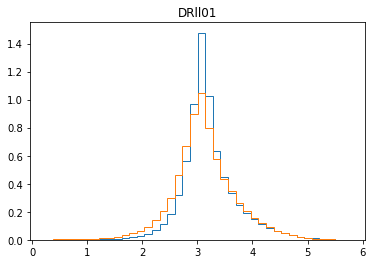

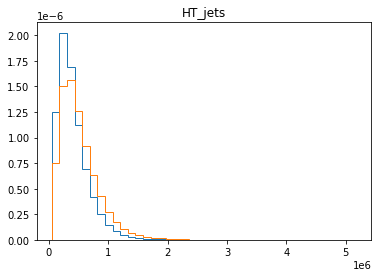

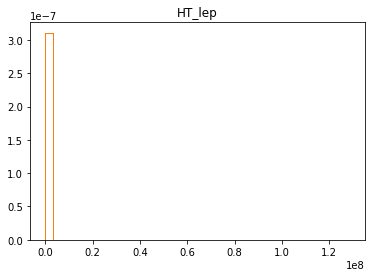

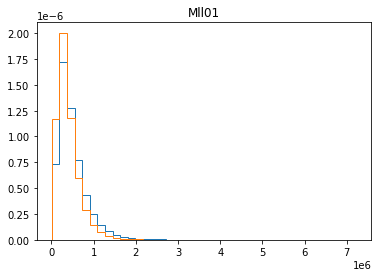

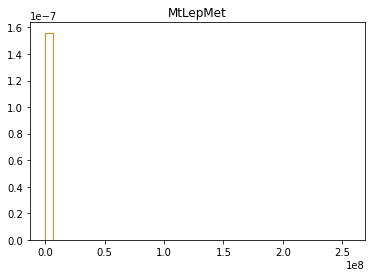

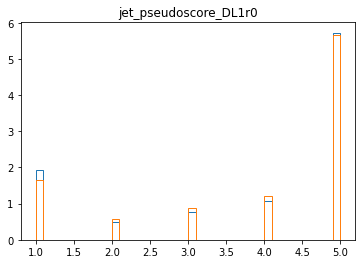

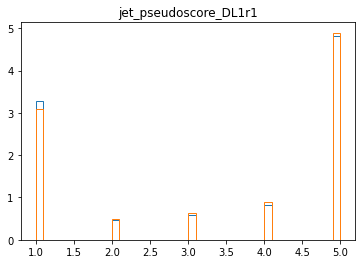

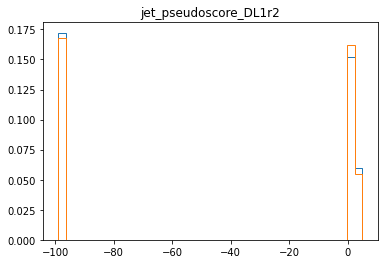

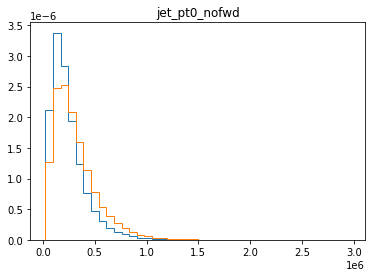

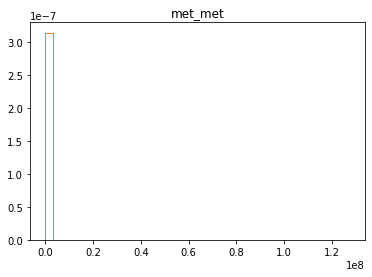

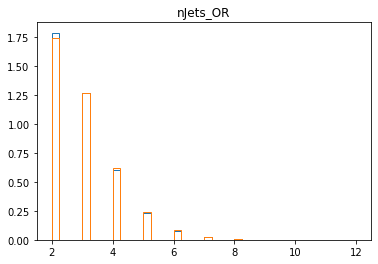

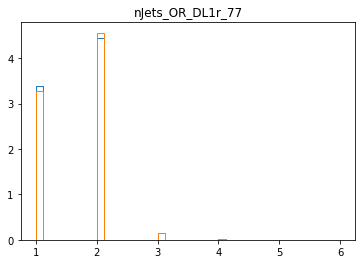

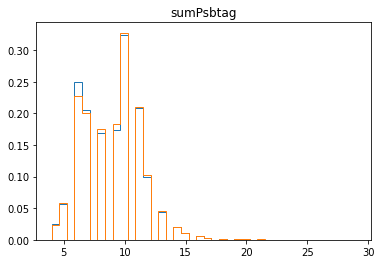

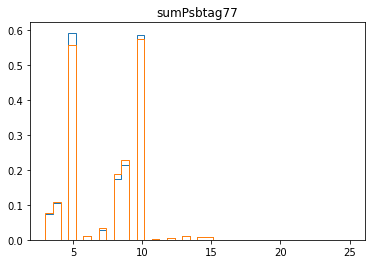

In [177]:
for i in range(inputs.shape[1]):
    plt.title(str(feature_names[i]))
    max_val = inputs[:,i].max()
    min_val = inputs[:,i].min()
    plt.hist(inputs[:,i], bins=40, histtype='step', weights = weights_cuu, density=True)
    plt.hist(inputs[:,i], bins=40, histtype='step', weights = weights_cqu, density=True)
    plt.show()

In [170]:
input_shape = train[0].shape[1]
n_epochs = 5
batch_size = 20000

In [168]:
layer_opts = dict( activation = 'sigmoid', kernel_initializer = initializers.glorot_normal(seed=seed))
input_layer = Kl.Input(shape = input_shape )
x = Kl.Dense( 36, **layer_opts) (input_layer)
x = Kl.Dense( 48, **layer_opts) (x)
x = Kl.Dense( 48, **layer_opts) (x)
y_pred = Kl.Dense( 1., activation = 'sigmoid', name = "OutputLayer" )(x)
model = Km.Model(inputs= input_layer, outputs=y_pred )
model_optimizer = Adam(lr=0.0001)
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_10 (Dense)             (None, 36)                612       
_________________________________________________________________
dense_11 (Dense)             (None, 48)                1776      
_________________________________________________________________
dense_12 (Dense)             (None, 48)                2352      
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 49        
Total params: 4,789
Trainable params: 4,789
Non-trainable params: 0
_________________________________________________________________


In [171]:
fit_hist = model.fit(train[0], train[1], epochs = n_epochs, shuffle = True, batch_size = batch_size, validation_data = (val[0],val[1]))

Train on 22763992 samples, validate on 3161666 samples
Epoch 1/5
22763992/22763992 [==============================] - 11s 0us/sample - loss: 0.6175 - accuracy: 0.6563 - val_loss: 0.6173 - val_accuracy: 0.6566
Epoch 2/5
22763992/22763992 [==============================] - 11s 0us/sample - loss: 0.6172 - accuracy: 0.6565 - val_loss: 0.6171 - val_accuracy: 0.6565
Epoch 3/5
22763992/22763992 [==============================] - 11s 0us/sample - loss: 0.6170 - accuracy: 0.6566 - val_loss: 0.6171 - val_accuracy: 0.6564
Epoch 4/5
22763992/22763992 [==============================] - 12s 1us/sample - loss: 0.6169 - accuracy: 0.6567 - val_loss: 0.6168 - val_accuracy: 0.6568
Epoch 5/5
22763992/22763992 [==============================] - 12s 1us/sample - loss: 0.6168 - accuracy: 0.6567 - val_loss: 0.6168 - val_accuracy: 0.6569


In [182]:
NN_out_train = model.predict(train[0])
NN_out_test = model.predict(test[0])

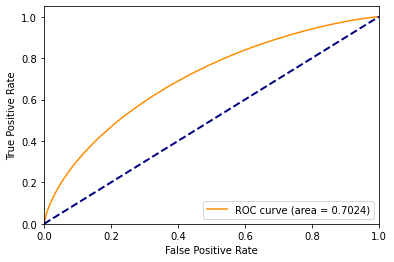

In [180]:
fpr, tpr, thr = roc_curve(test[1], NN_out_test)
roc_auc = auc(fpr, tpr)

fig = plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(path_tosave+"/ROC.png")
plt.show()

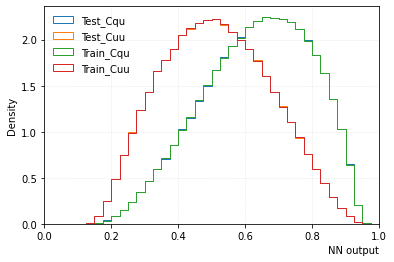

In [184]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
histargs = {"bins":40, "range":(0,1.), "density":True, "histtype":'step'}
plt.hist(NN_out_test[test[1]==1],label = "Test_Cqu", **histargs)
plt.hist(NN_out_test[test[1]==0],label = "Test_Cuu", **histargs)
plt.hist(NN_out_train[train[1]==1],label = "Train_Cqu", **histargs)
plt.hist(NN_out_train[train[1]==0],label = "Train_Cuu", **histargs)
plt.legend(loc='upper left', frameon=False,)
saveit = "{}/{}".format(path_tosave, "DNN_Output.png")
plt.savefig(saveit)

# Testing with not really reweighted Data

In [186]:
inputs_test = scaler.transform(inputs)

In [187]:
inputs_test.shape

(253953, 16)

In [188]:
NN_out_notreweighted = model.predict(inputs_test)

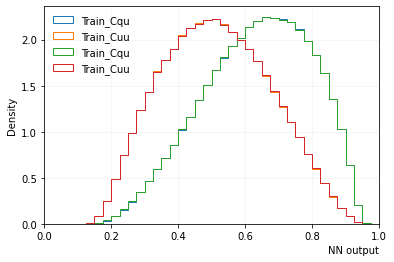

In [197]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
histargs = {"bins":40, "range":(0,1.), "density":True, "histtype":'step'}
plt.hist(NN_out_train[train[1]==1],label = "Train_Cqu", **histargs)
plt.hist(NN_out_train[train[1]==0],label = "Train_Cuu", **histargs)
plt.hist(NN_out_notreweighted, label = "Train_Cqu", **histargs, weights=weights_cqu)
plt.hist(NN_out_notreweighted, label = "Train_Cuu", **histargs, weights=weights_cuu)
plt.legend(frameon=False, loc='upper left')
plt.show()

Saving architecture to: /mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/SvS/architecture.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/SvS/weights.h5


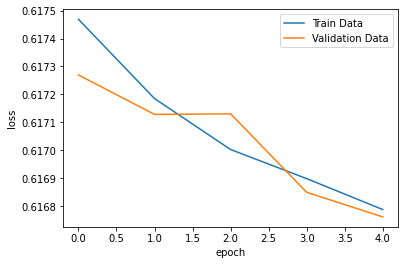

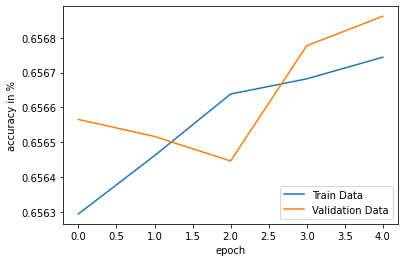

In [193]:
fit_history = []
fit_history.append(fit_hist)
Save_Model(model, path_tosave)
Plot_Metrics(fit_history, path_tosave)
pickle.dump(scaler, open(path_tosave + '/scaler.pkl','wb'))